# Deepwalk performance on hetionet alone

In this result file we examine how Deepwalk performed in Hetionet with specific edge types removed when we did not artifically preserve the gold standard nodes in the network.

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression

from glob import glob
import os
import seaborn as sns

In [2]:
%matplotlib inline

---

if no embedding for training data


In [3]:
def add_features(df, features, mergetype):
    return (df
        .merge(
            features, how=mergetype, left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how=mergetype, left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

def convolv_features(df, features, vecsize, mergetype):
    reg = add_features(df, features, mergetype)
    
    # do multiply and get rid of old features
    for i in range(vecsize):
        reg["conv{}".format(i)] = reg["f{}_x".format(i)] * reg["f{}_y".format(i)]

    reg = (reg
        .drop(
            ["f{}_x".format(i) for i in range(vecsize)], axis=1
        )
        .drop(
            ["f{}_y".format(i) for i in range(vecsize)], axis=1
        )
    )
        
    return reg

there are nodes in the holdout dataset that did not have any embeddings generated for it. check to see if they had proper adjlists made

In [4]:
def eval_performance(fbase, K, vecsize):
    for idx in range(K):
        train = pd.read_csv(
            "tmp/data/train/{}_train_{}.tsv".format(fbase, idx),
            sep='\t'
        )
        
        holdout = pd.read_csv(
            "tmp/data/holdout/{}_holdout_{}.tsv".format(fbase, idx),
            sep='\t'
        )

        features = pd.read_csv(
            "tmp/data/embeddings/{}_embedding_{}.txt".format(fbase, idx),
            sep=" ", skiprows=1,
            names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
        )

        tmp = convolv_features(train, features, vecsize, "inner")

        feat_cols = ["conv{}".format(j) for j in range(vecsize)]
        regmodel = LogisticRegression(C=1e9).fit(tmp[feat_cols], tmp["etype"])

        # test on holdout
        test = convolv_features(
            holdout.drop("etype", axis=1),
            features, vecsize, "left"
        )
        
        assert len(test) == len(holdout)
        
        # if there are empty ones in the features column,
        # then we didn't generate any embeddings, and therefore
        # need to split those up and treat as zeroes
        # for the others we can predict normally, then join together
        
        regular = test[test["conv0"].notnull()].assign(missed = False)
        
        missed = (test[test["conv0"].isnull()]
            .assign(
                predval = 0
            )
            .assign(missed = True)
        )
                
        # add in predictions
        ans = regular.assign(
            predval = lambda df: regmodel.predict_proba(df[feat_cols])[:, 1]
        )
        
        ans = ans.append(missed)
        
        assert len(ans) == len(holdout)
        
        yield (ans
            [["chemical_uid", "disease_uid", "predval", "missed"]]
            .merge(
                holdout[["chemical_uid", "disease_uid", "etype"]],
                how="inner", on=["chemical_uid", "disease_uid"]
            )
            .sort_values("predval", ascending=False)
            .reset_index(drop=True)
        )

In [5]:
def finished(fbase, K):
    for i in range(K):
        ename = "tmp/data/embeddings/{}_embedding_{}.txt".format(fbase, i)
        
        if not os.path.isfile(ename):
            return False

    return True

need to check that we have the expected embeddings for the concepts

In [6]:
vecsize = 128

missed = []
for edge_fname in tqdm(glob("tmp/edges/*.tsv")):
    fbase = edge_fname.split("/")[2][:-4]
    
    vals = fbase.split("_")
    
    pct_kept = vals[2]
    assert len(pct_kept) <= 2
    pct_kept = int(pct_kept)
    
    K = 3 if pct_kept == 0 else 2
    
    # check if all K embeddings are done
    if finished(fbase, K):

        aucs = []
        for res in eval_performance(fbase, K, vecsize):
            fpr, tpr, thresh = roc_curve(res["etype"], res["predval"])

            auc_val = auc(fpr, tpr)
            aucs.append(auc_val)
            
            missed.append((res["missed"].sum(), len(res), len(res.query("missed and etype == 1"))))

        temp = (pd
            .Series(aucs)
            .to_frame("auc_roc")
            .assign(edge_val = fbase)
        )
        
        temp.to_csv(
            "tmp/results/{}.tsv".format(fbase), sep='\t', index=False
        )

100%|██████████| 126/126 [12:21<00:00,  5.88s/it]


---

In [7]:
mdata = pd.DataFrame(missed, columns=["num_missed", "total", "missed_and_true"])

In [8]:
mdata.shape

(266, 3)

In [9]:
mdata.head()

,num_missed,total,missed_and_true
0,550,94014,2
1,271,92628,1
2,0,92081,0
3,0,84960,0
4,268,91068,1


In [10]:
mdata.sort_values("missed_and_true", ascending=False).head(10)

,num_missed,total,missed_and_true
48,10695,92394,34
47,9576,92623,28
46,7109,84587,24
249,4914,92651,16
248,3060,87619,11
214,3806,93356,11
213,3096,86294,10
167,2800,90982,9
96,2401,89484,7
168,1932,88094,6


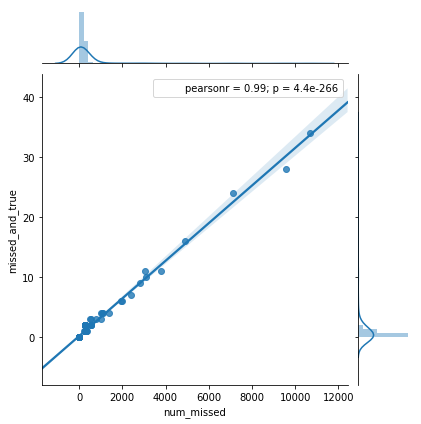

In [11]:
sns.jointplot(data=mdata, x="num_missed", y="missed_and_true", kind="reg")

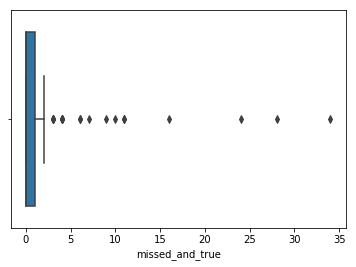

In [12]:
sns.boxplot(mdata["missed_and_true"])

roughly 600 true indications out of 85k total things to predict in our holdout sets. so a maximum of 30 missed would equate to 5% of the total things to predict, which seems significant.

---

In [13]:
res = [
    pd.read_csv(fname, sep='\t')
    for fname in glob("tmp/results/*.tsv")
]

res = pd.concat(res)

In [14]:
res.shape

(266, 2)

In [15]:
res.head()

,auc_roc,edge_val
0,0.827653,Pharmacologic Class_Compound_60_kept_1
1,0.813983,Pharmacologic Class_Compound_60_kept_1
0,0.812413,Compound_Compound_40_kept_0
1,0.816909,Compound_Compound_40_kept_0
0,0.830784,Pharmacologic Class_Compound_60_kept_0


In [16]:
data = (res
    .assign(
        pct_kept = lambda df:
            df["edge_val"].str.split("_").str[2].pipe(pd.to_numeric)
    )
    .assign(
        edge_type = lambda df:
            df["edge_val"].str.split("_").str[0:2].map("_".join)
    )
    .sort_values(["edge_type", "pct_kept"])
)

In [17]:
data.head()

,auc_roc,edge_val,pct_kept,edge_type
0,0.828584,Anatomy_Gene_0_kept,0,Anatomy_Gene
1,0.829685,Anatomy_Gene_0_kept,0,Anatomy_Gene
2,0.830464,Anatomy_Gene_0_kept,0,Anatomy_Gene
0,0.823712,Anatomy_Gene_20_kept_1,20,Anatomy_Gene
1,0.829951,Anatomy_Gene_20_kept_1,20,Anatomy_Gene


In [18]:
data["edge_type"].value_counts()

Compound_Compound               19
Disease_Symptom                 19
Gene_Gene                       19
Disease_Disease                 19
Gene_Biological Process         19
Gene_Molecular Function         19
Disease_Anatomy                 19
Compound_Side Effect            19
Anatomy_Gene                    19
Disease_Gene                    19
Pharmacologic Class_Compound    19
Compound_Gene                   19
Gene_Cellular Component         19
Gene_Pathway                    19
Name: edge_type, dtype: int64

---

In [28]:
# original deepwalk performance on unmodified hetionet
orig = [0.83794169828897624,
 0.83592900230751011,
 0.82794024342944517,
 0.83258454954099403,
 0.84911988472878375,
 0.82679078477519785,
 0.86955409367485537,
 0.81721305005383327,
 0.82568604664477641,
 0.85703519382275861]

In [30]:
hetio_perf = (pd
    .Series(orig)
    .to_frame("auc_roc")
    .assign(pct_kept = 100)
)

In [31]:
hetio_perf.head()

,auc_roc,pct_kept
0,0.837942,100
1,0.835929,100
2,0.827940,100
3,0.832585,100
4,0.849120,100


In [37]:
temp = []
for i in data["edge_type"].unique():
    temp.append(hetio_perf.assign(edge_type = i))
    
temp = pd.concat(temp)

In [38]:
temp.head()

,auc_roc,pct_kept,edge_type
0,0.837942,100,Anatomy_Gene
1,0.835929,100,Anatomy_Gene
2,0.827940,100,Anatomy_Gene
3,0.832585,100,Anatomy_Gene
4,0.849120,100,Anatomy_Gene


---

In [40]:
data = data.append(temp)

---

In [41]:
avgs = (data
    .groupby(["edge_type", "pct_kept"])
    .mean()
    .reset_index()
)

In [42]:
avgs.shape

(84, 3)

In [44]:
avgs.head(6)

,edge_type,pct_kept,auc_roc
0,Anatomy_Gene,0,0.829578
1,Anatomy_Gene,20,0.828406
2,Anatomy_Gene,40,0.820241
3,Anatomy_Gene,60,0.828478
4,Anatomy_Gene,80,0.834696
5,Anatomy_Gene,100,0.837979


---

the only kind of clear trend we see is with gene and molecular function edges, but the large error bars relative to the actual amount in AUC changed makes it difficult to conclude if there was actually a real effect. The other edge types removed seemed to make no real difference. maybe this is a result of us artifically subsetting things.

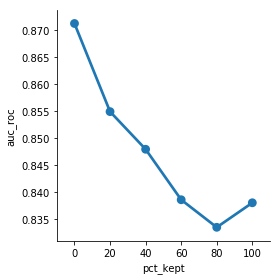

In [46]:
sns.factorplot(
    data=avgs.query("edge_type == 'Compound_Side Effect'"),
    x="pct_kept", y="auc_roc"
)

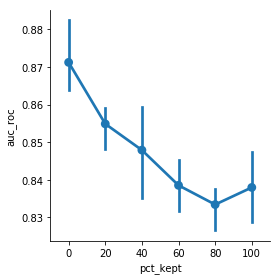

In [47]:
sns.factorplot(
    data = data.query("edge_type == 'Compound_Side Effect'"),
    x="pct_kept", y="auc_roc"
)

---

- why does compound side effect get better with fewer edges?? is the result significant??
- should we be expecting a greater drop off in performance from the edge removal?


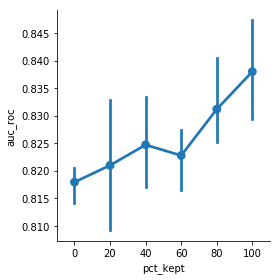

In [50]:
sns.factorplot(
    data = data.query("edge_type == 'Gene_Pathway'"),
    x="pct_kept", y="auc_roc"
)

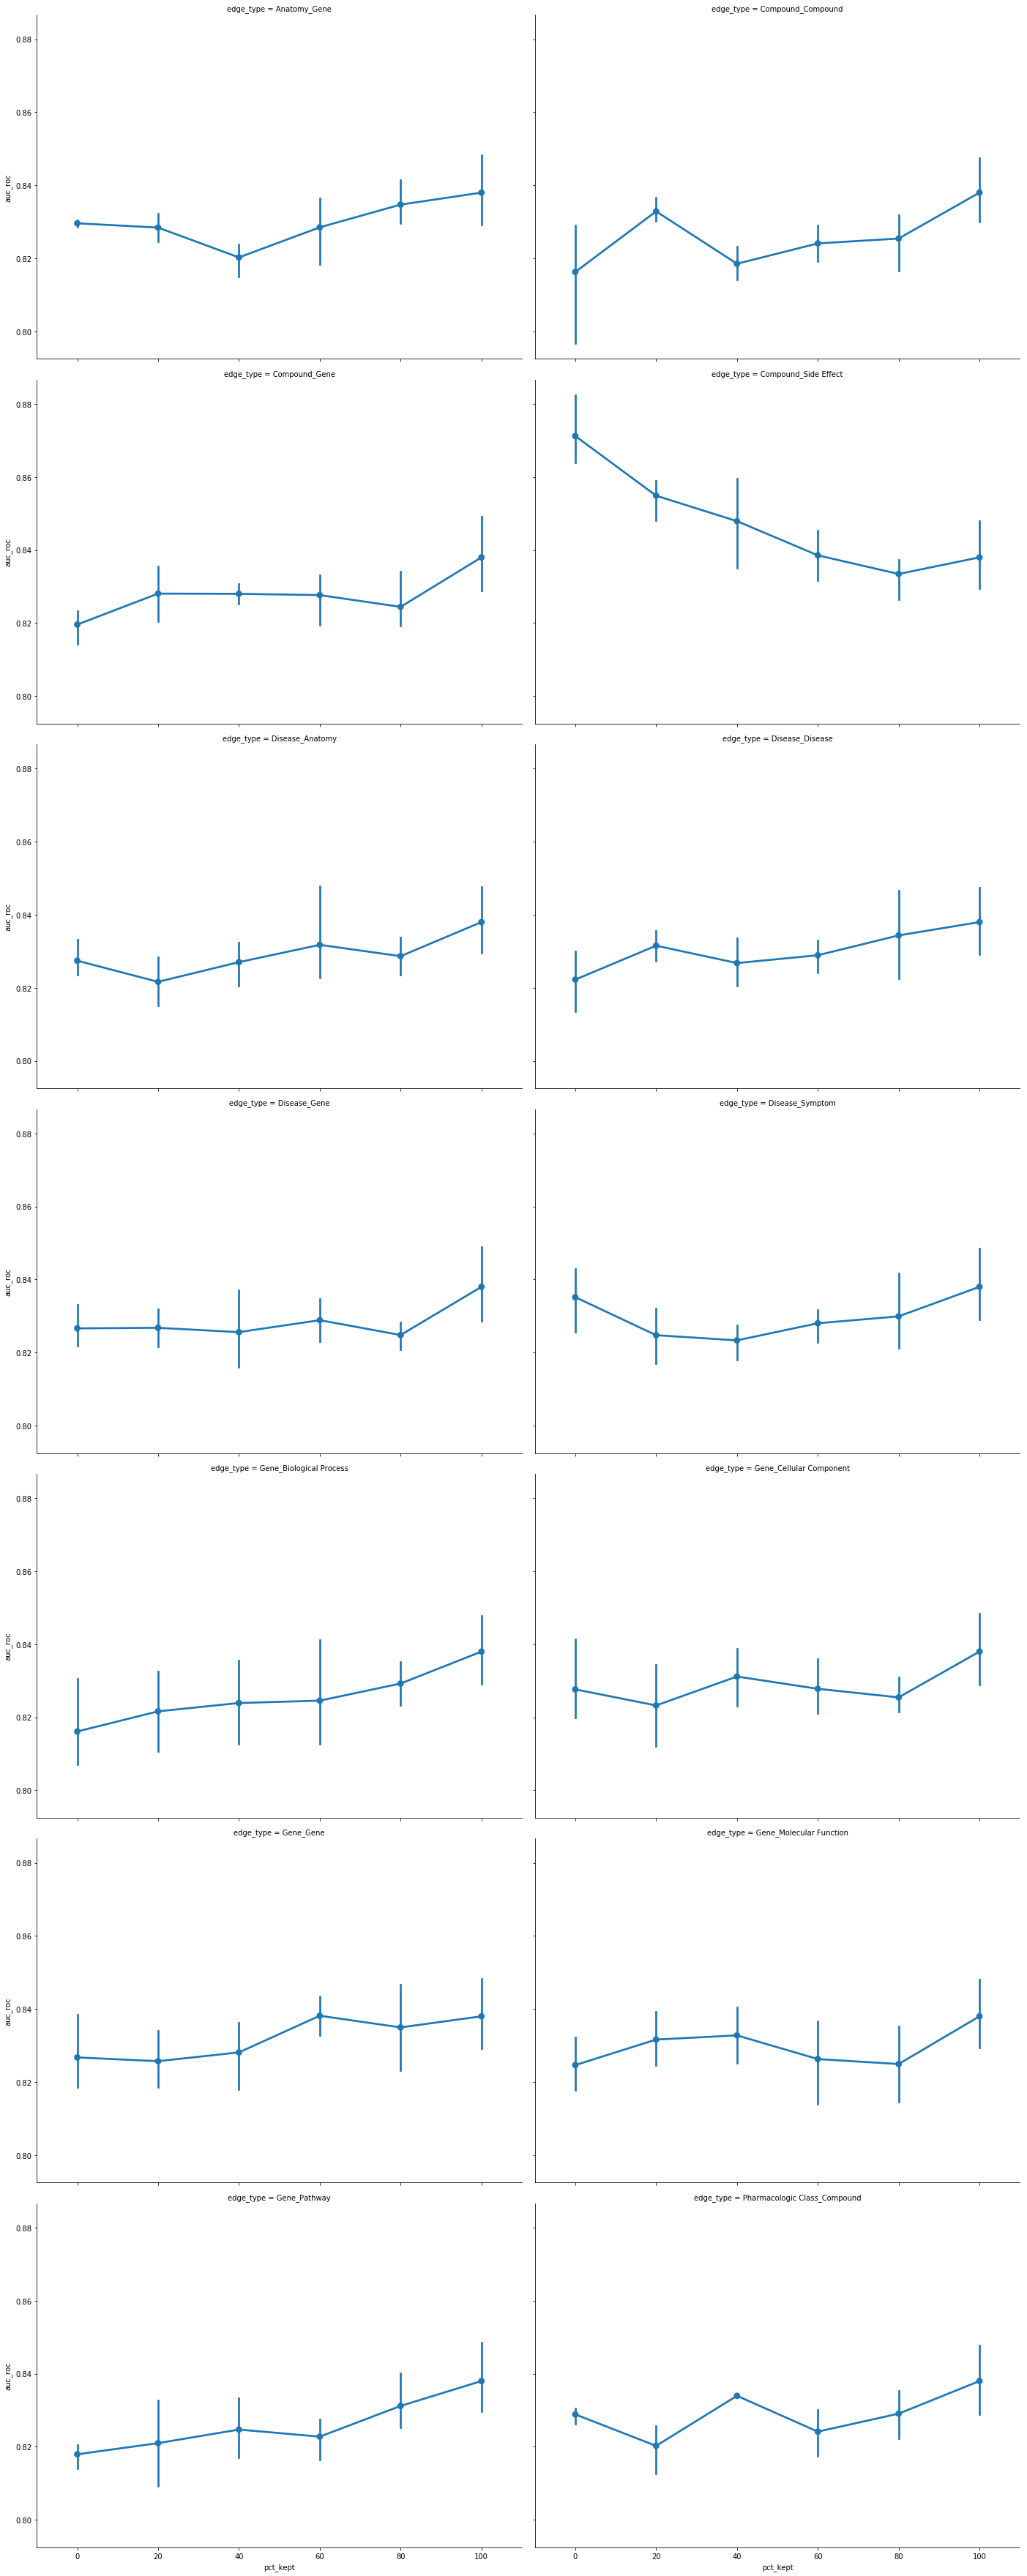

In [48]:
sns.factorplot(
    data=data, x="pct_kept", y="auc_roc",
    col="edge_type", col_wrap=2, size=7, aspect=1.4
)

---

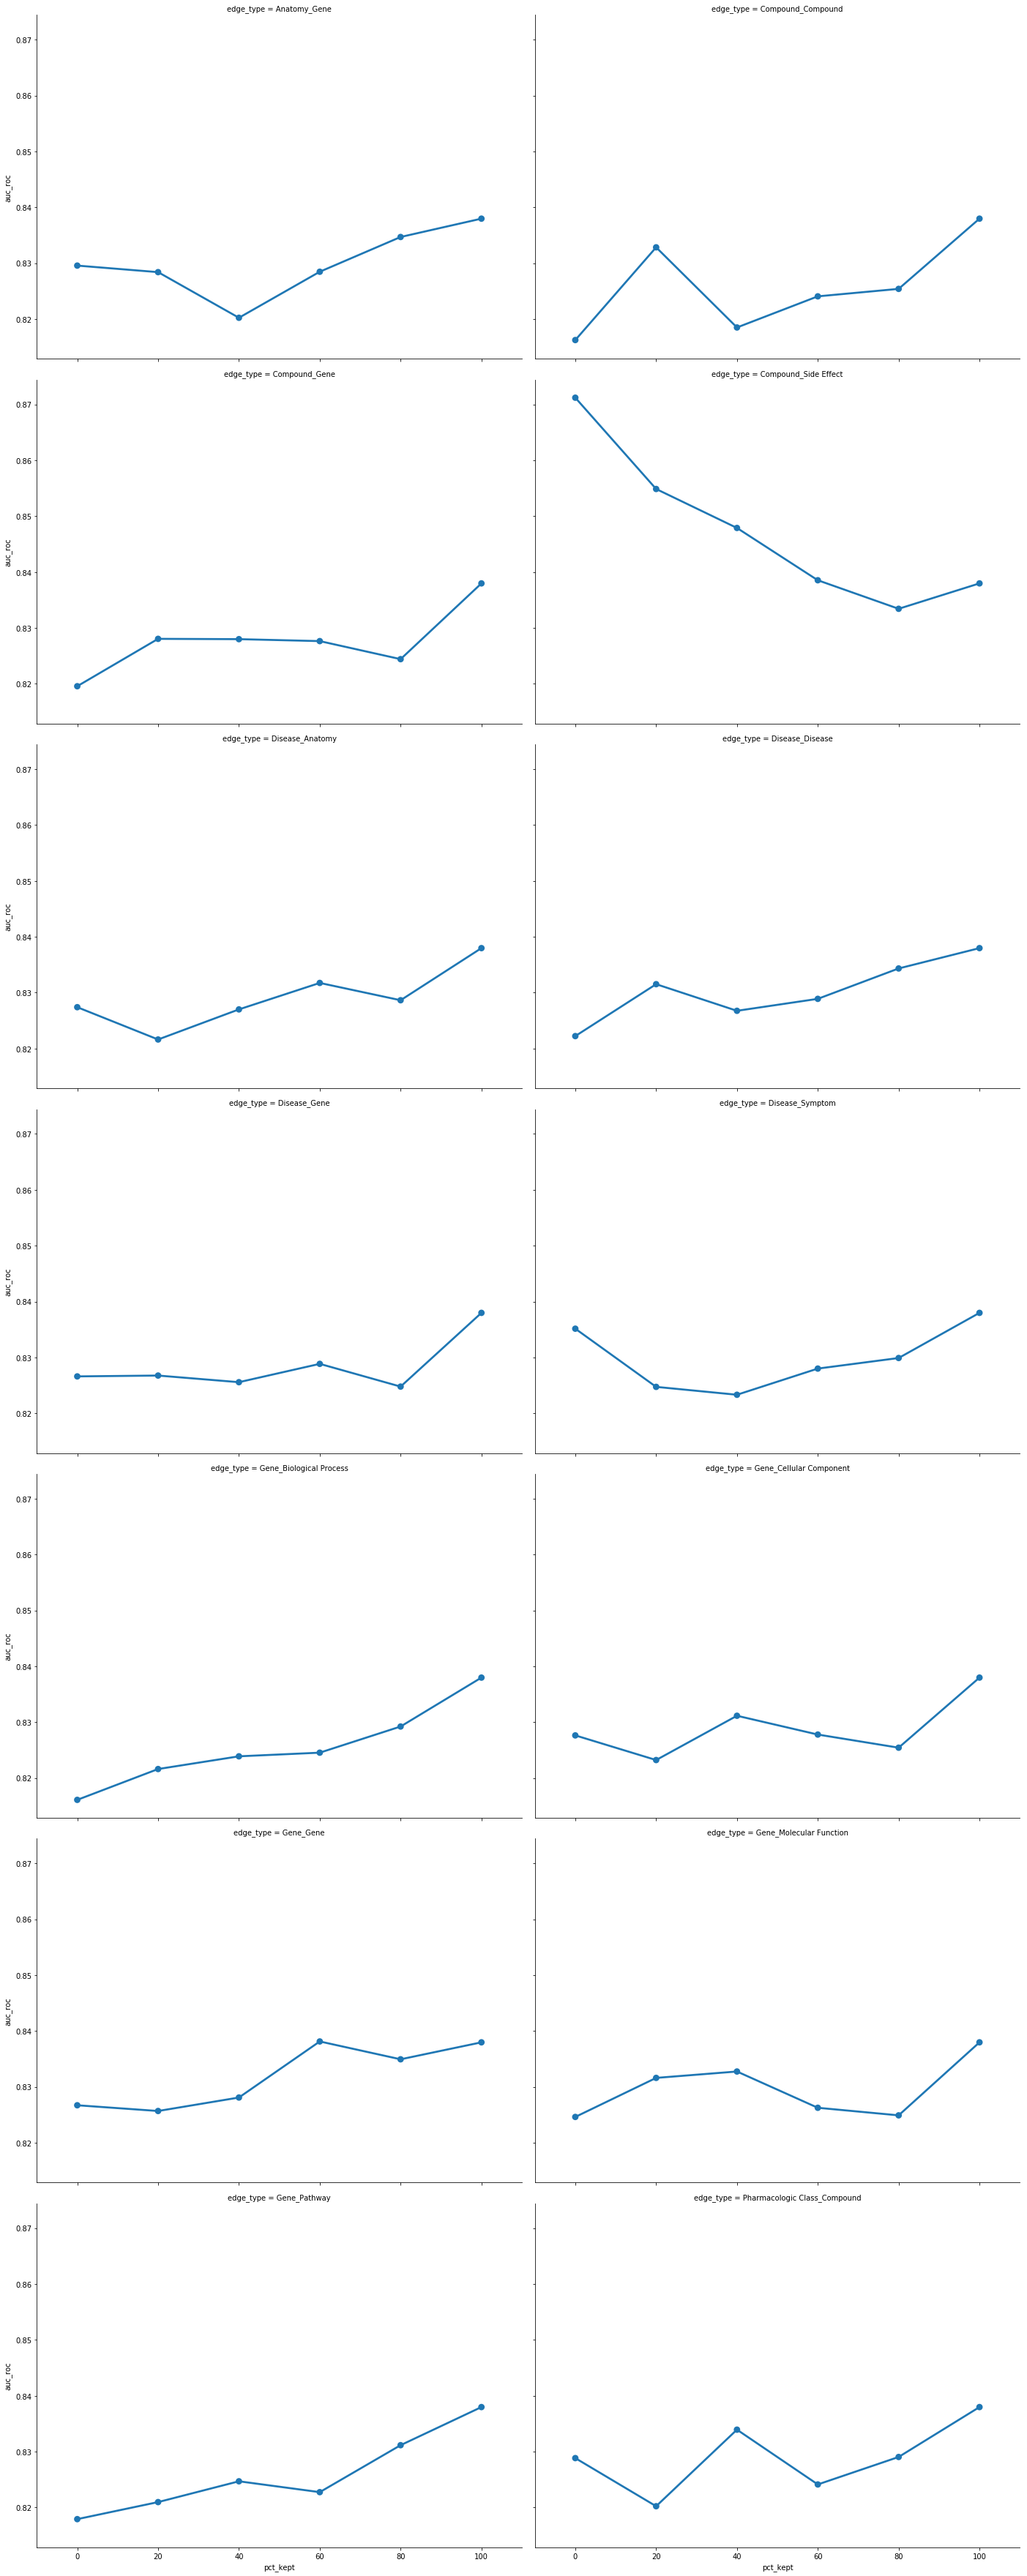

In [49]:
sns.factorplot(
    data=avgs, x="pct_kept", y="auc_roc",
    col="edge_type", col_wrap=2, size=7, aspect=1.4
)